```
Print file contents and attributes:
h5dump -n 1 TEOB_dataI.hdf5

Copy data from vulcan:
gsiscp vulcan2.aei.mpg.de:/work/mpuer/projects/gpsurrogate/test_40Hz_1D/TEOB_dataI.hdf5 .

Try this for fitting out a line:
import scipy.signal as signal
signal.detrend(x)

Try a Hilbert transform for the Amplitude of the Fourier transform instead of a moving average. Maybe that will work better to low-pass filter and smooth the function ~A(f). Can also try it for ~Phi(f). It might avoid the bias that results from using too long of an averaging window.

Window out merger waveform as was done with SpinTaylorT4 if the surrogate looks terrible, to check that nothing in the inspiral is causing the surrogate problems.
```

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.stats as stats

In [3]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [4]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)

import constants
imp.reload(constants)
from constants import *

In [5]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

#from scipy import stats
import h5py
import glob

In [6]:
def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

# Condition waveform for training set

## Functions for matching to TaylorF2 at beginning

In [47]:
orig_filename = '../data/TEOBv4_40hz/TEOB_data_1d.hdf5'
paramslist, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


0.000394039282043


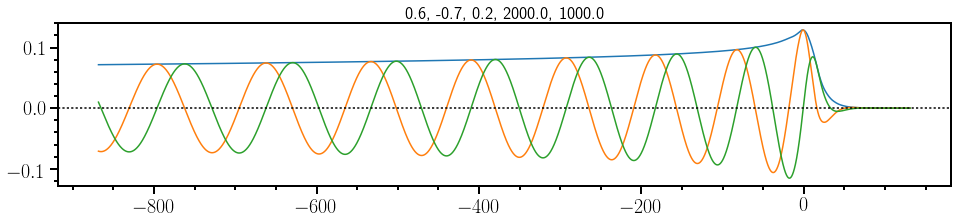

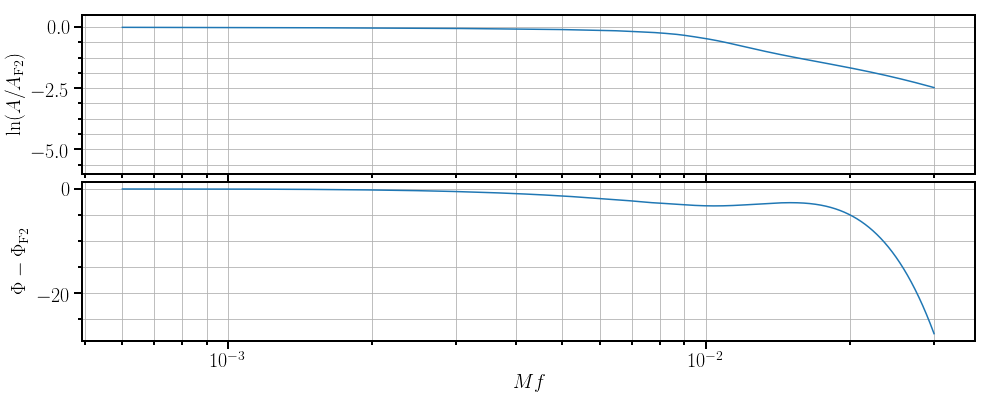

In [58]:
i = 0

h = hlist[i]
params = paramslist[i]

delta_t = 10.

mflow = f_to_mf(40., 2.)
print mflow

winon_i = mflow
winon_f = 0.00045

fit_i = 0.0006
fit_f = fit_i + 0.0001

trunc_i = fit_i
trunc_f = 0.03

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

npoints = 10000
win = 'planck'
filter_dfbyf_amp = 0.2
filter_dfbyf_phase = 0.05

h, hf2, dh = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=True)

In [59]:
dh.phase

array([  0.00000000e+00,  -1.63960106e-06,   7.78494267e-06, ...,
        -2.76736346e+01,  -2.77156168e+01,  -2.77576518e+01])

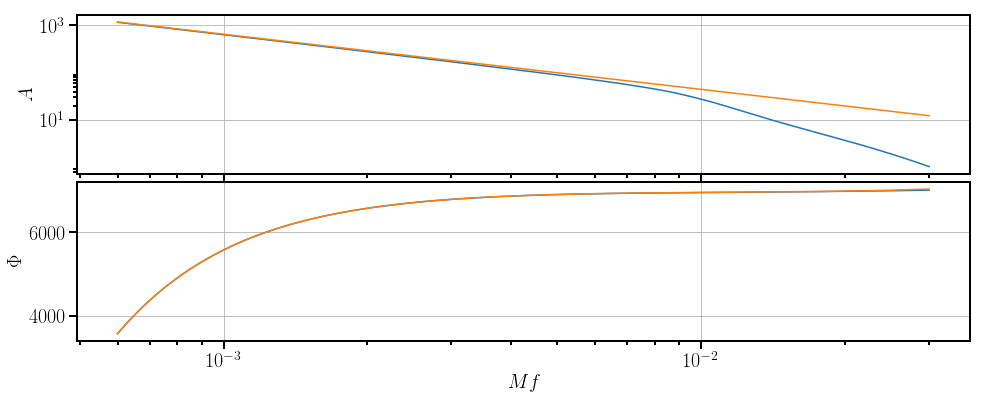

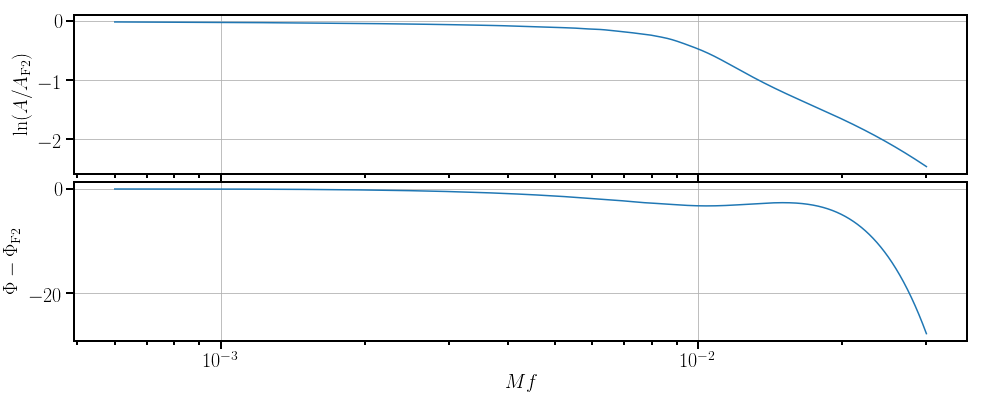

In [55]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h, hf2])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.05, 0.0)

In [72]:
h_list = hlist
params = paramslist
h_filename = '../data/teobtest40hz/h_test_1d.hdf5'
dh_filename = '../data/teobtest40hz/dh_test_1d.hdf5'

delta_t = 10.

mflow = f_to_mf(40., 2.)
print mflow

winon_i = mflow
winon_f = 0.00045

fit_i = 0.0006
fit_f = fit_i + 0.0001

trunc_i = fit_i
trunc_f = 0.03

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

npoints = 10000
win = 'planck'
filter_dfbyf_amp = 0.2
filter_dfbyf_phase = 0.05

traineob.condition_eob_training_set_from_list(
    h_list, params, h_filename, dh_filename,
    delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f,
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

0.000394039282043
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [73]:
h_test = ws.HDF5WaveformSet('../data/teobtest40hz/h_test_1d.hdf5')
dh_test = ws.HDF5WaveformSet('../data/teobtest40hz/dh_test_1d.hdf5')

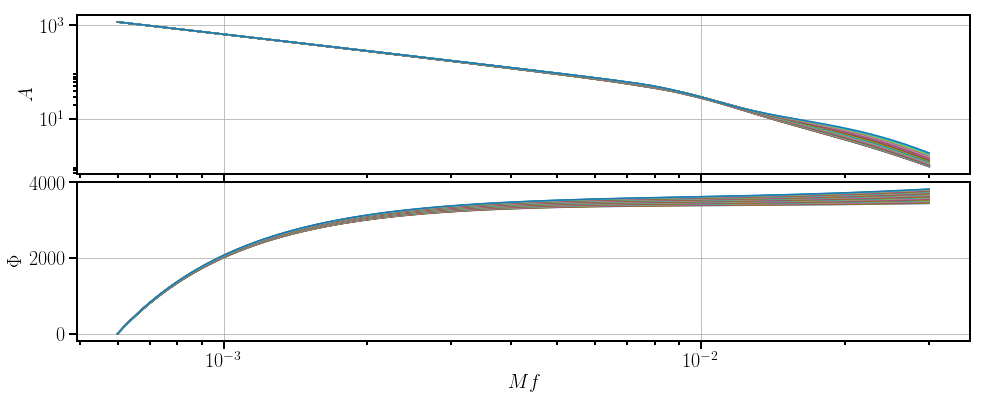

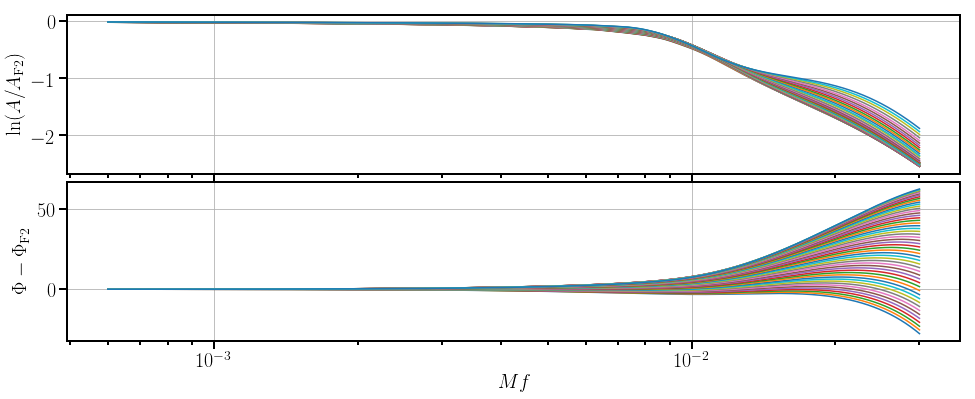

In [74]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_test[i] for i in range(len(h_test))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_test[i] for i in range(len(dh_test))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.05, 0.0)

0.01 1015.12721759
8.33988317786 4.03005189353


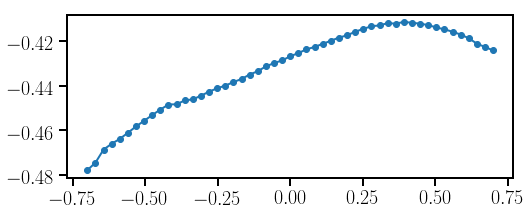

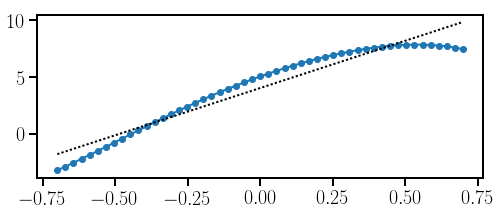

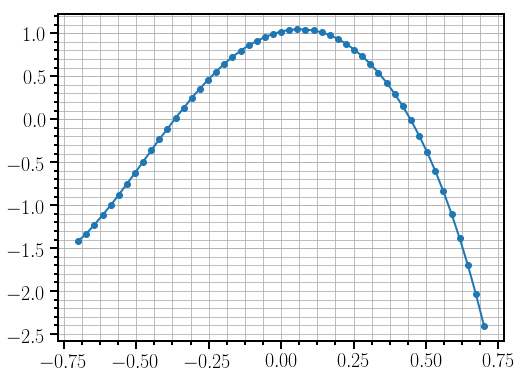

In [75]:
mf = 0.01
print mf, mf_to_f(mf, 2.)

spin1z_arr = np.array([dh_test.get_waveform(i, data='parameters')[1] for i in range(len(dh_test))])

ps = []
amps = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    h = dh_test[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    dh = dh_test[i]
    phase = dh.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
print slope, intercept

x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)
axes.minorticks_on()
axes.grid(which='both')
#axes.set_ylim(-2, -1)

# Old

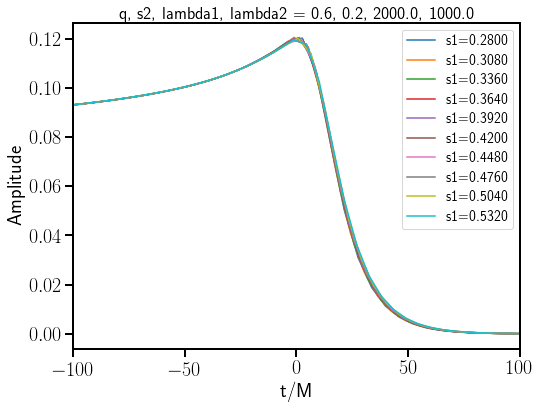

In [13]:
fig, ax = plt.subplots()
for i in range(35, 45):
    p = params[i]
    h = hlist[i]
    ax.plot(h.x, h.amp, label='s1={:.4f}'.format(p[1]))

ax.set_xlim(-100, 100)
ax.legend()
title = 'q, s2, lambda1, lambda2 = {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[2], p[3], p[4])
ax.set_title(title)
ax.set_xlabel('t/M')
ax.set_ylabel('Amplitude')

In [14]:
mflow = f_to_mf(40., 2.)
print mflow

delta_t = 10.
winon_i = mflow
winon_f = 0.00050

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time
print n_ext
trunc_i = 0.0007
trunc_f = 0.03


h_filename = '../data/teobtest40hz/h_test_1d.hdf5'
dh_filename = '../data/teobtest40hz/dh_test_1d.hdf5'

traineob.condition_eob_training_set_from_list(
    hlist, params, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=0.2,
    filter_dfbyf_phase=0.05,
    plots=False, 
    mtot=2.0, distance=1.0)

0.000394039282043
17687982.9215
2097152
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


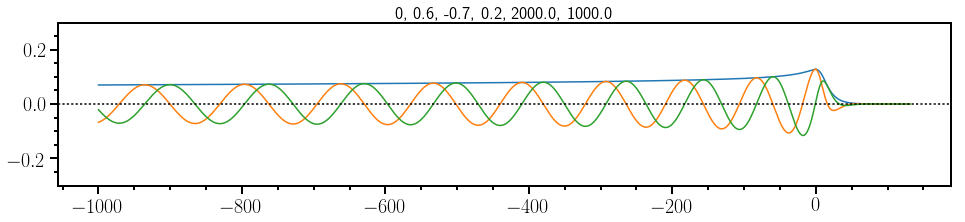

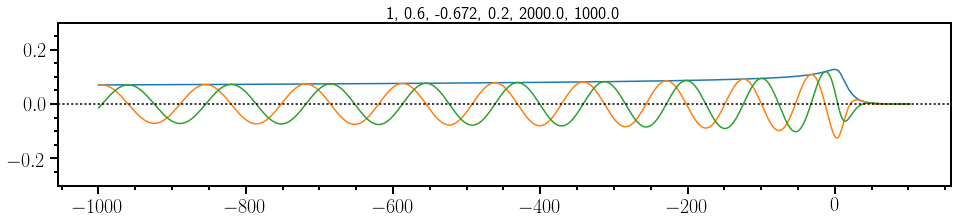

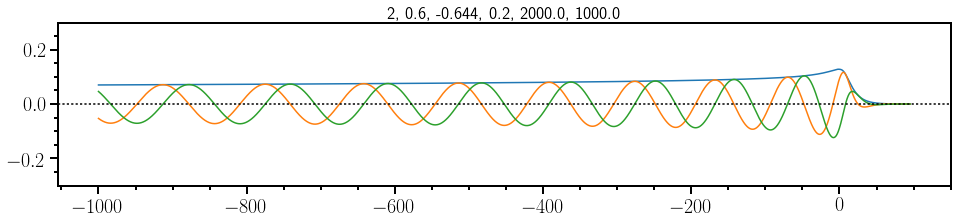

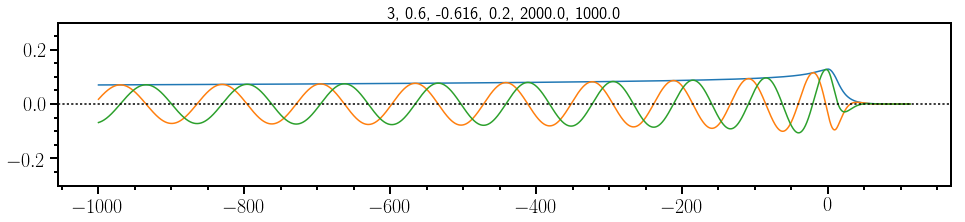

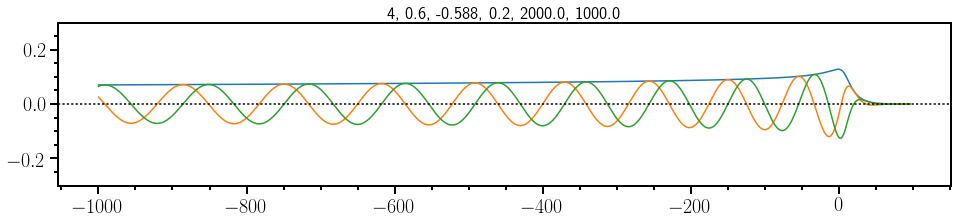

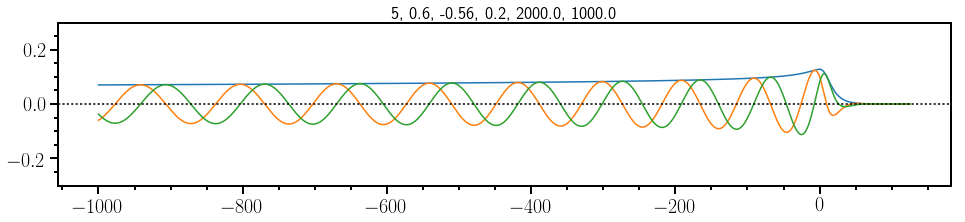

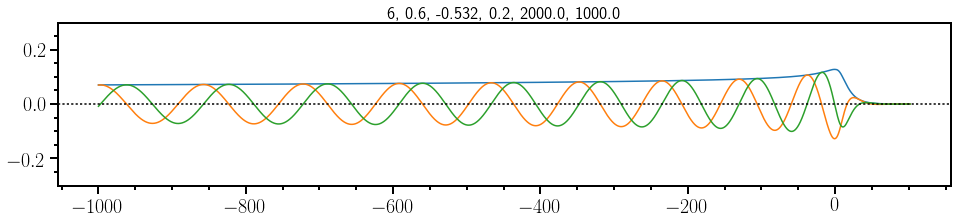

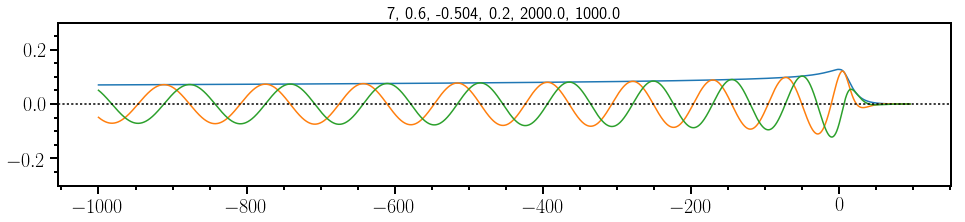

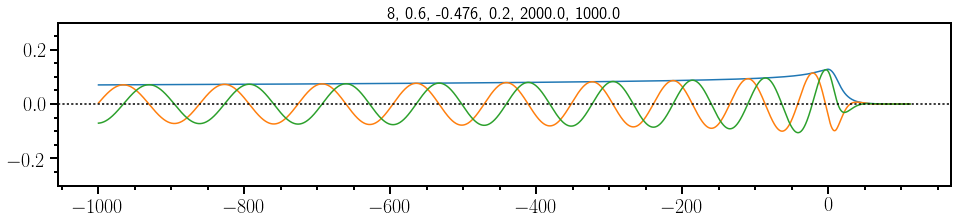

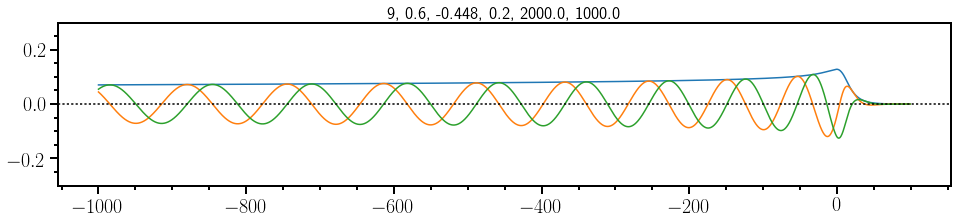

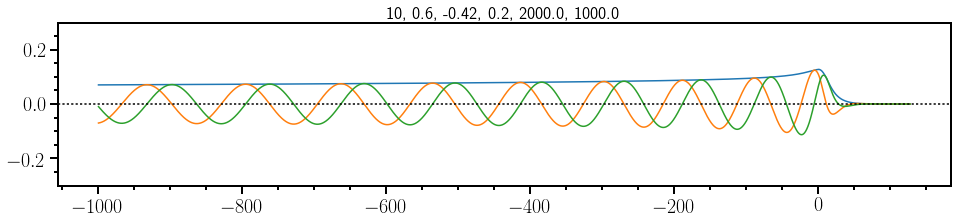

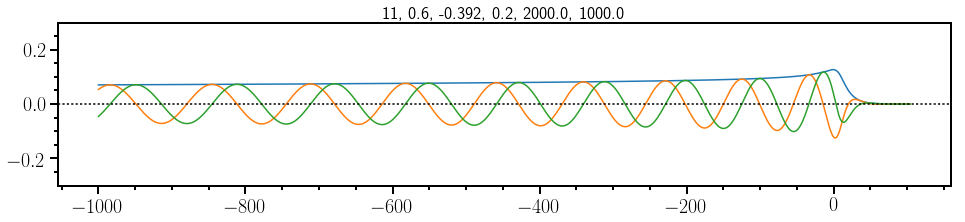

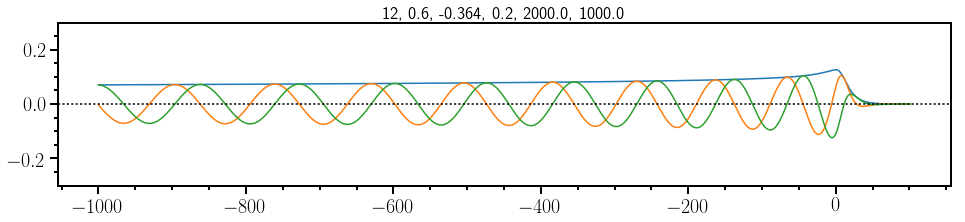

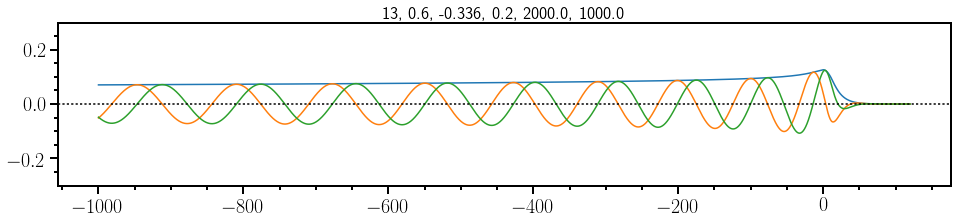

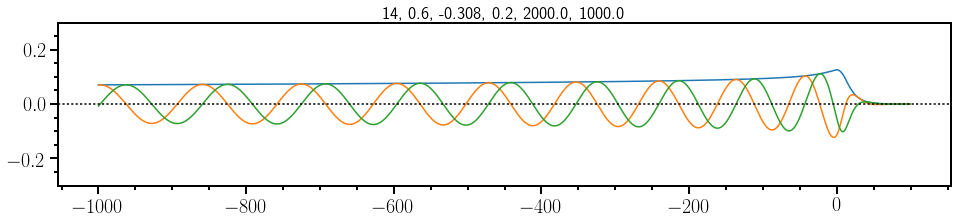

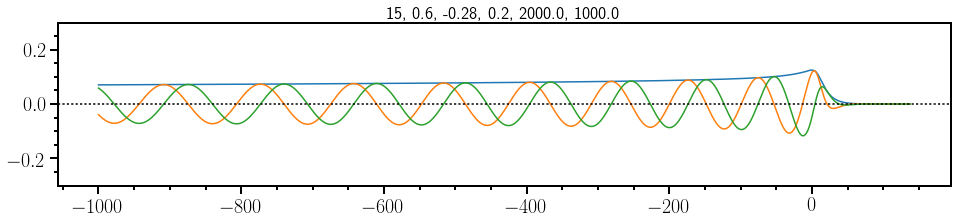

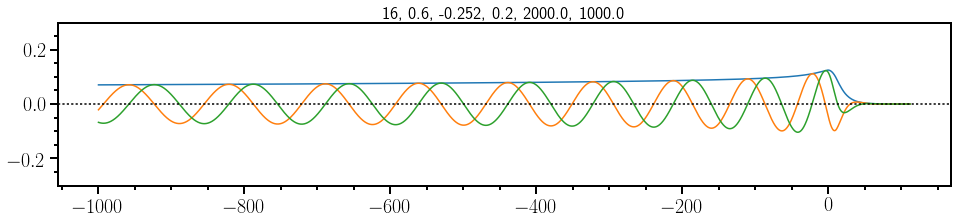

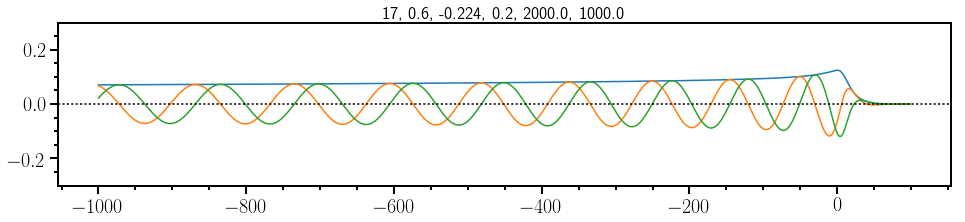

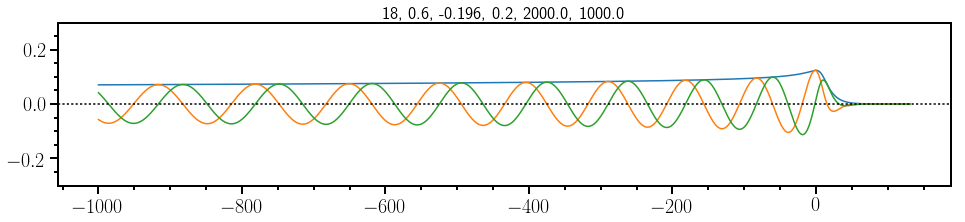

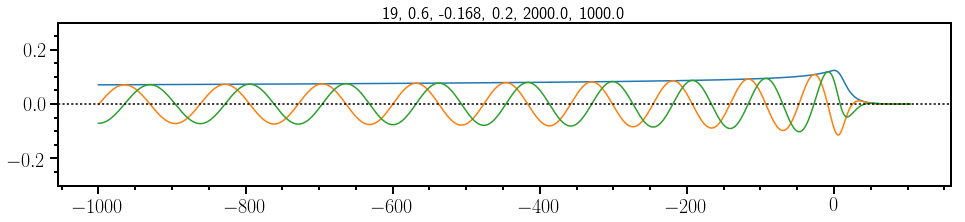

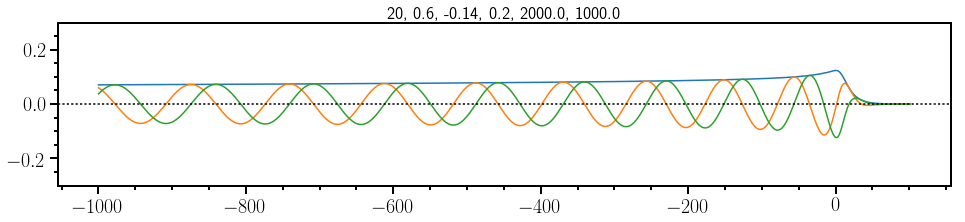

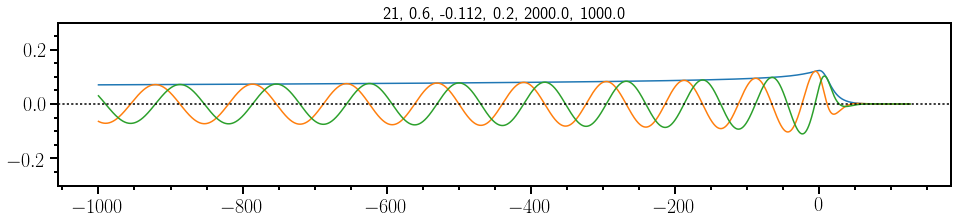

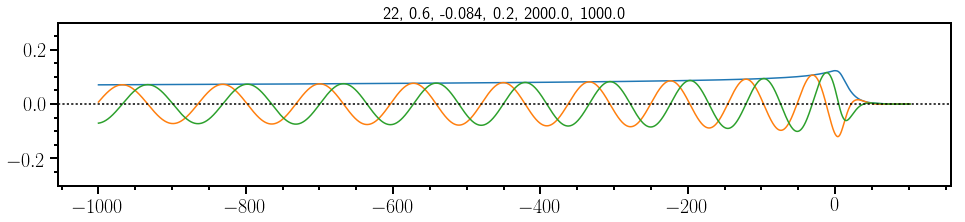

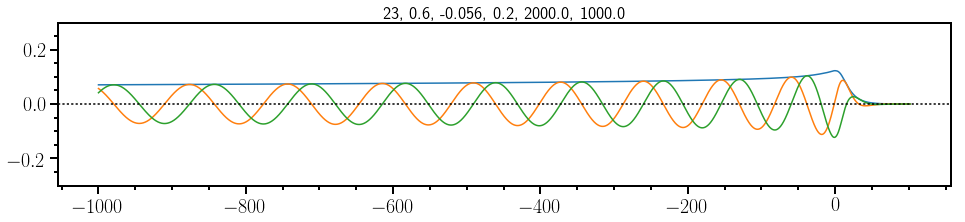

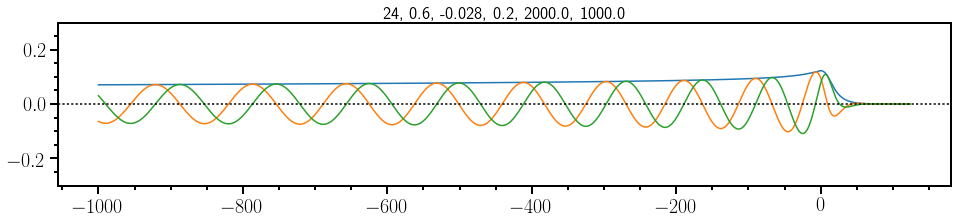

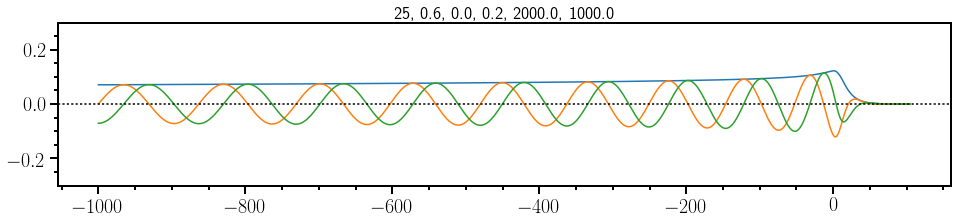

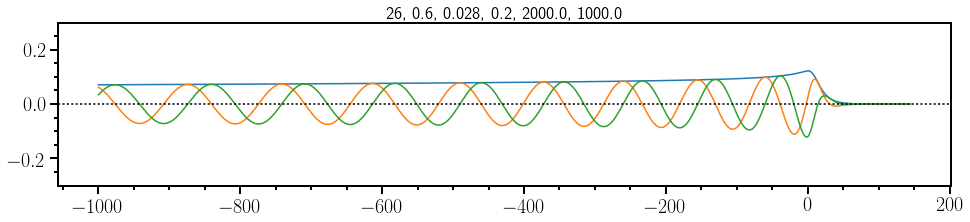

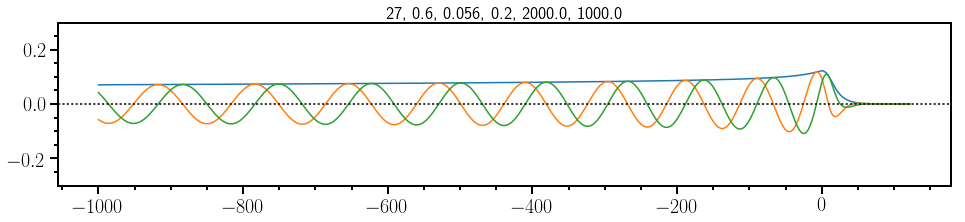

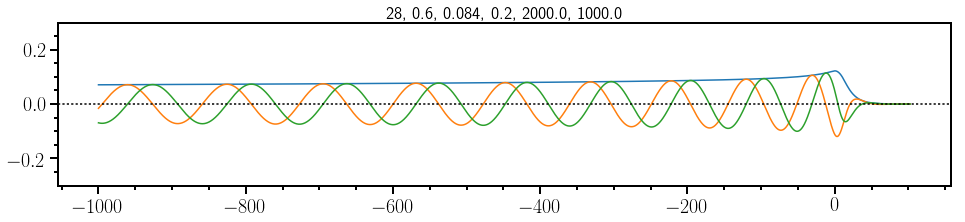

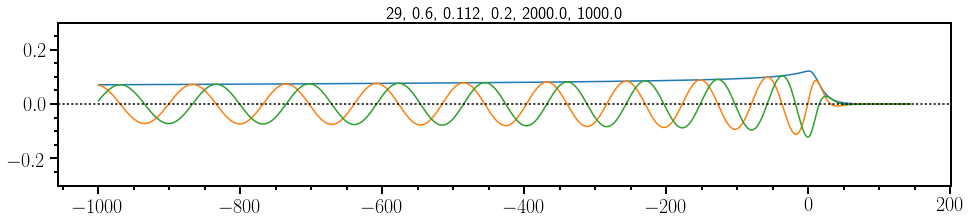

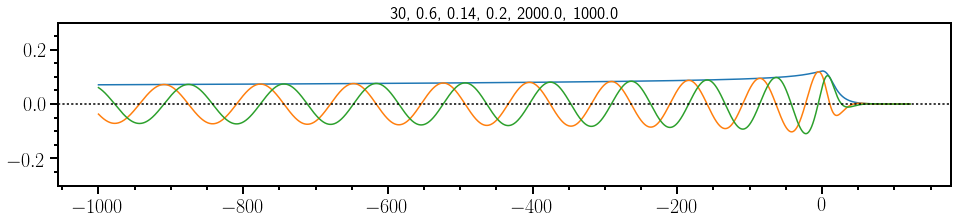

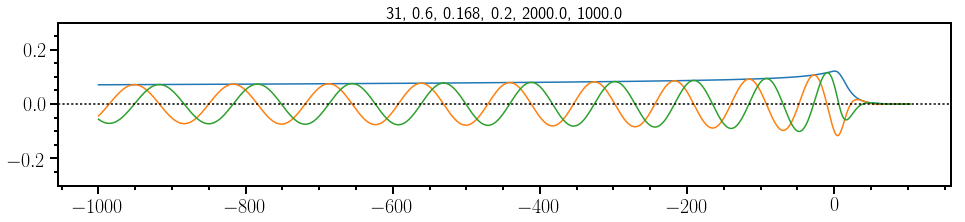

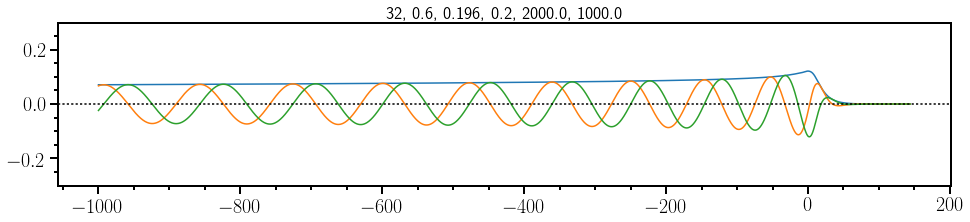

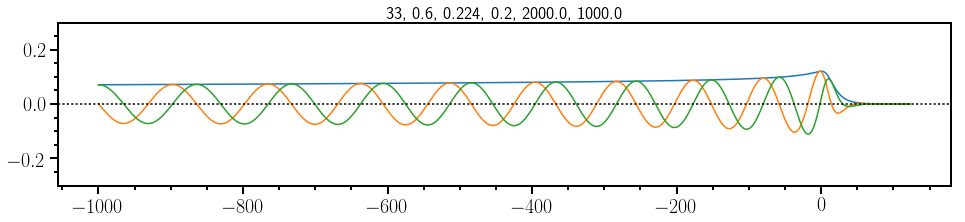

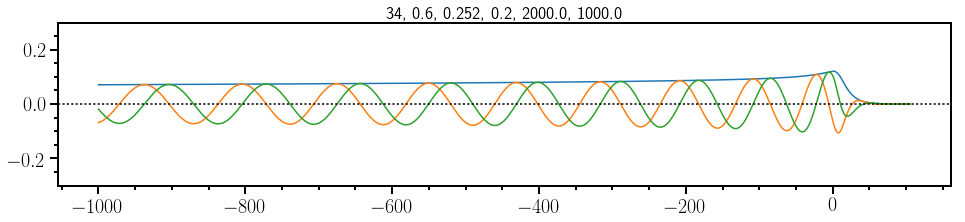

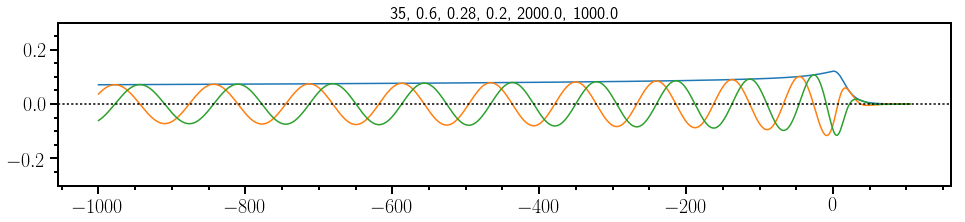

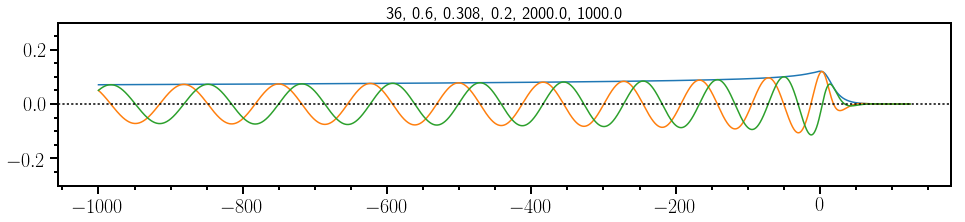

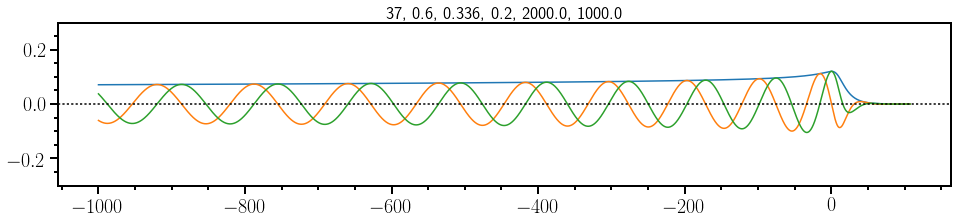

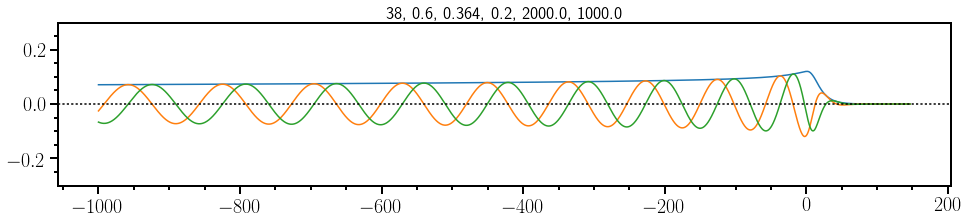

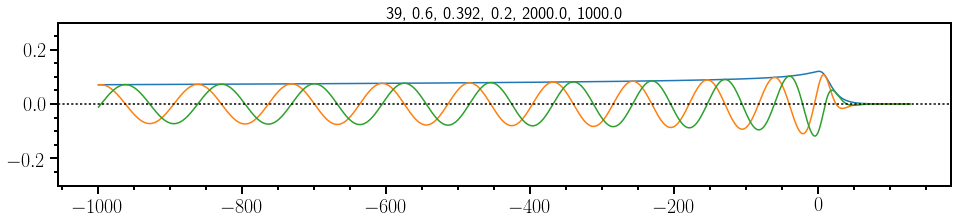

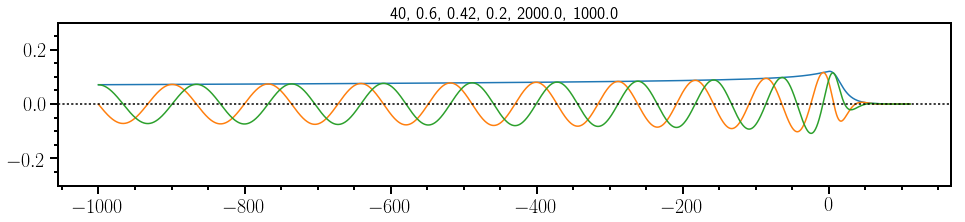

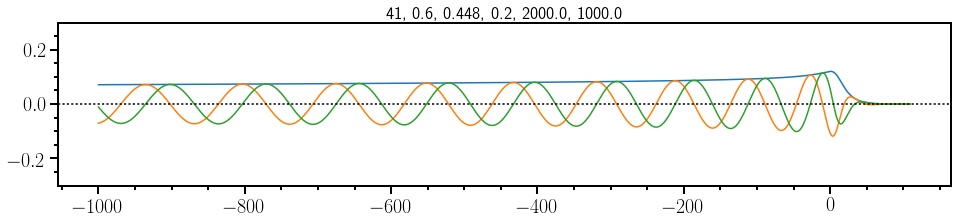

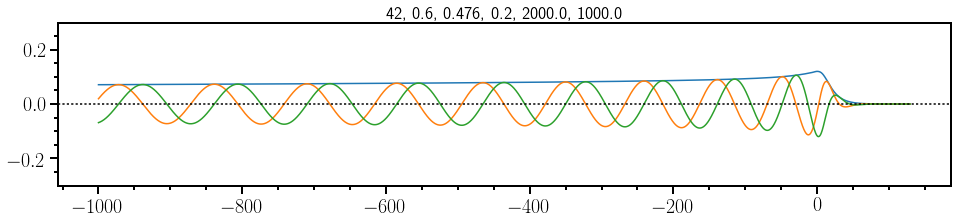

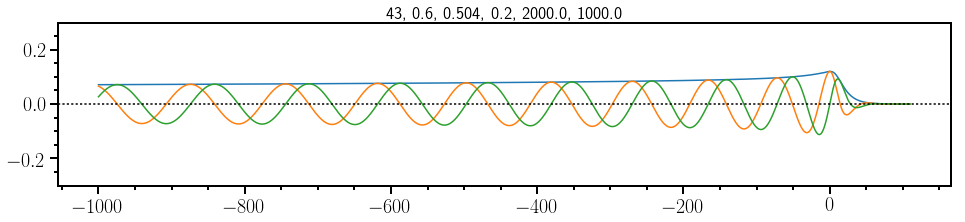

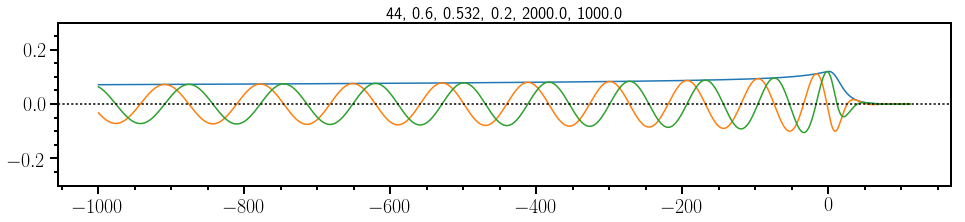

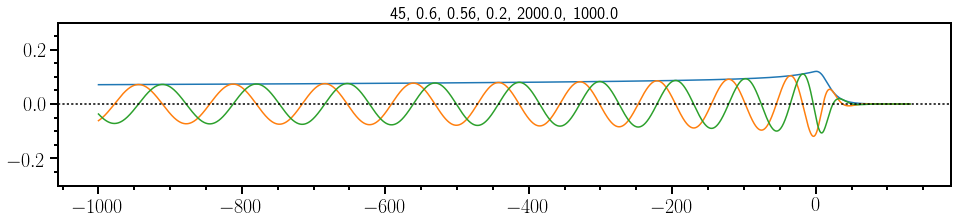

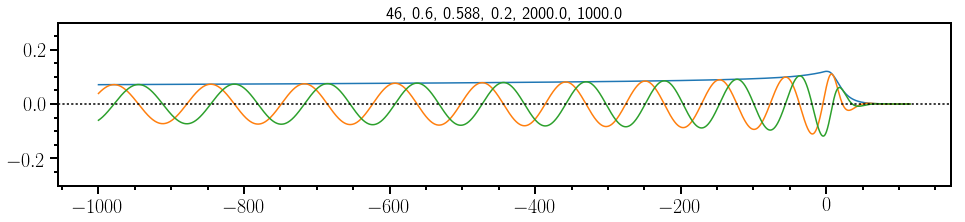

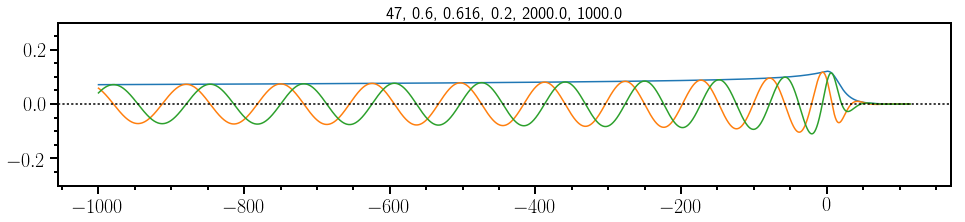

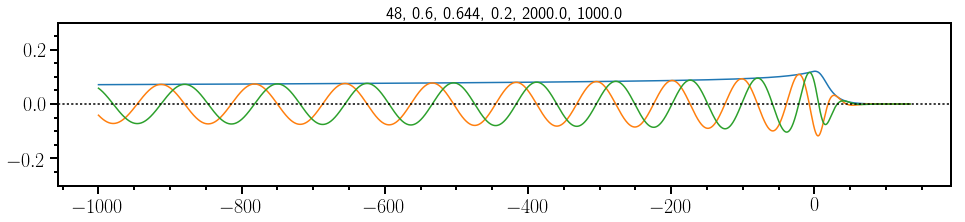

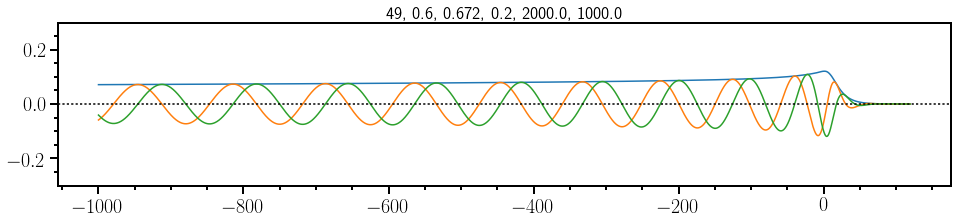

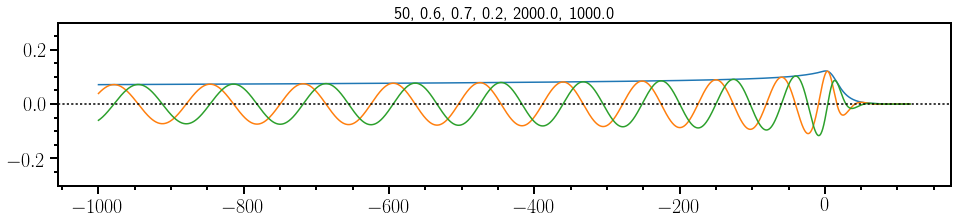

In [11]:
for i in range(len(hlist)):
    p = params[i]
    fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
    title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
    ax.set_title(title)
    ax.minorticks_on()
    ax.set_ylim(-0.3, 0.3)

In [16]:
h_test = ws.HDF5WaveformSet('../data/teobtest40hz/h_test_1d.hdf5')
dh_test = ws.HDF5WaveformSet('../data/teobtest40hz/dh_test_1d.hdf5')

dh_test.parameters().shape

(51, 5)

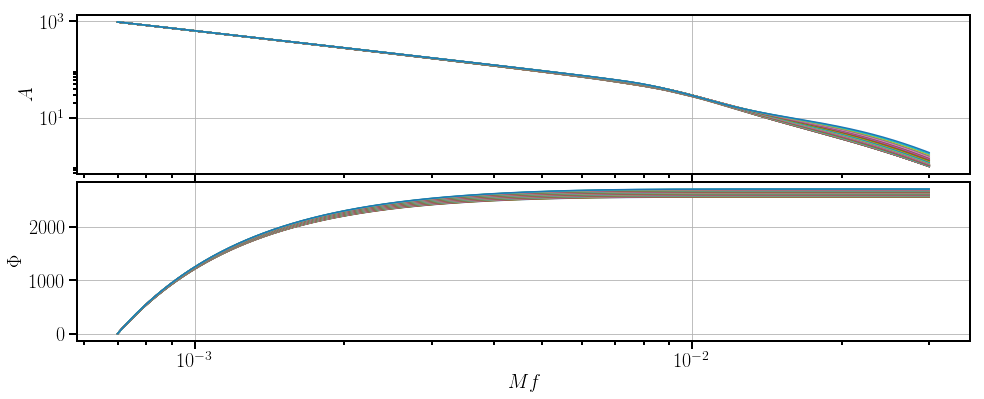

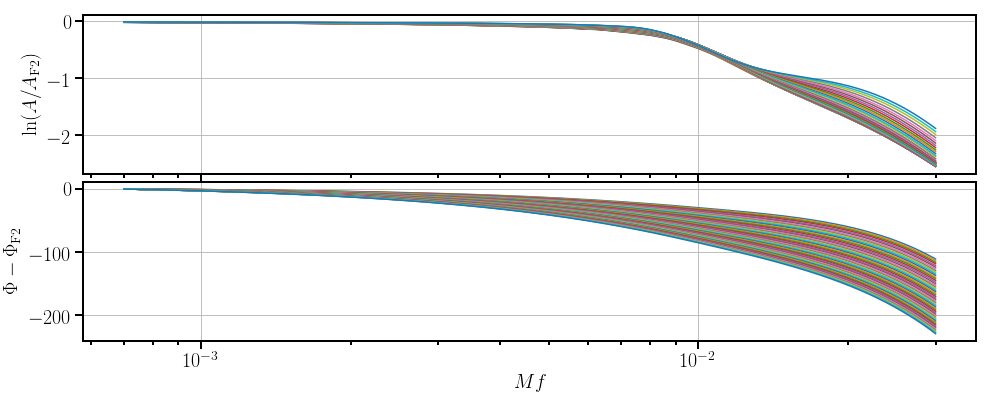

In [18]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_test[i] for i in range(len(h_test))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_test[i] for i in range(len(dh_test))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.05, 0.0)

0.005 507.563608793
-19.9764809222 -28.4739570006


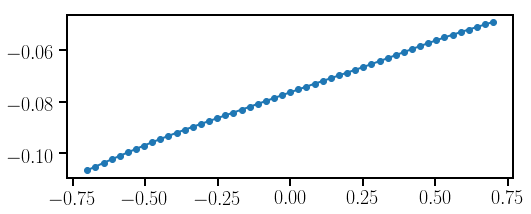

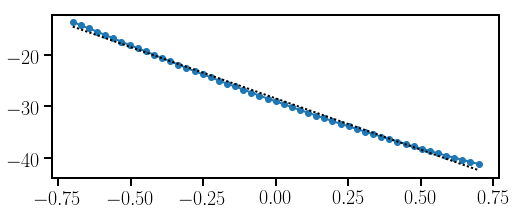

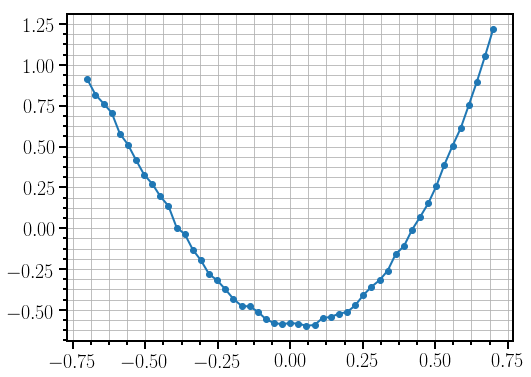

In [20]:
mf = 0.005
print mf, mf_to_f(mf, 2.)

spin1z_arr = np.array([dh_test.get_waveform(i, data='parameters')[1] for i in range(len(dh_test))])

ps = []
amps = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    h = dh_test[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    h = dh_test[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
print slope, intercept

x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)
axes.minorticks_on()
axes.grid(which='both')
#axes.set_ylim(-2, -1)

# Old stuff

# Cleaning Gibbs oscillations

In [22]:
orig_filename = '../../data/teobtest40hz/TEOB_data_train_corners_lhd.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159


(-500, 100)

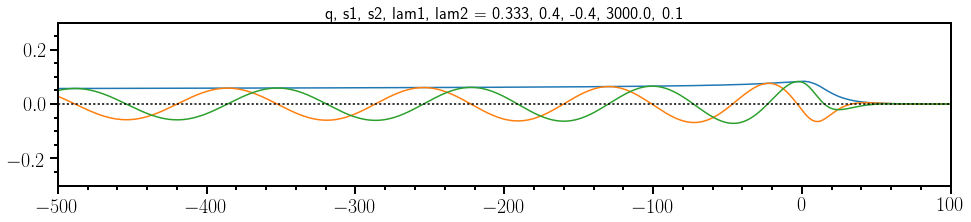

In [23]:
i=10
p = params[i]
fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-500, 100)

In [24]:
i=10
p = params[i]
h = hlist[i]


mflow = f_to_mf(40., 2.)
print mflow

delta_t = 10.
winon_i = mflow

#winon_f = 0.00050
winon_f = 0.001

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time
print n_ext
trunc_i = winon_f
trunc_f = 0.03

# No moving average filter
h1, hf21, dh1 = traineob.condition_eob_waveform(
    h, p, delta_t,
    winon_i, winon_f,
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=None, filter_dfbyf_phase=None, plots=False)

# Using moving average filter
h2, hf22, dh2 = traineob.condition_eob_waveform(
    h, p, delta_t,
    winon_i, winon_f,
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=0.2, filter_dfbyf_phase=0.05, plots=False)

0.000394039282043
17687982.9215
2097152


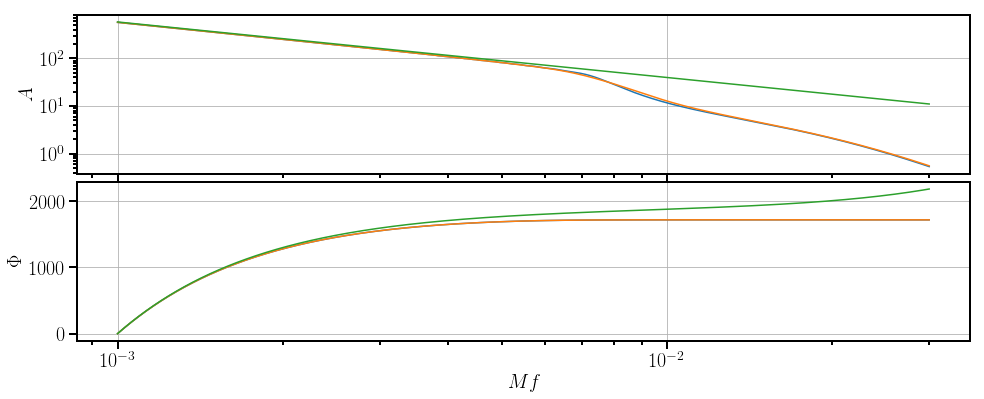

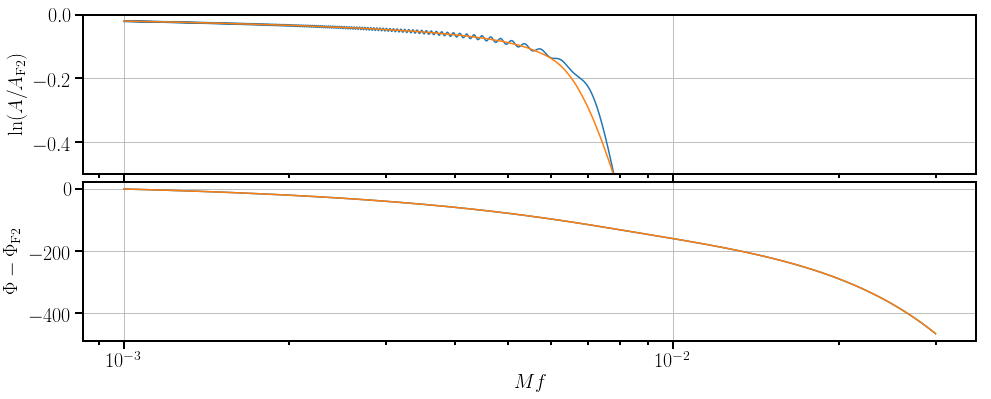

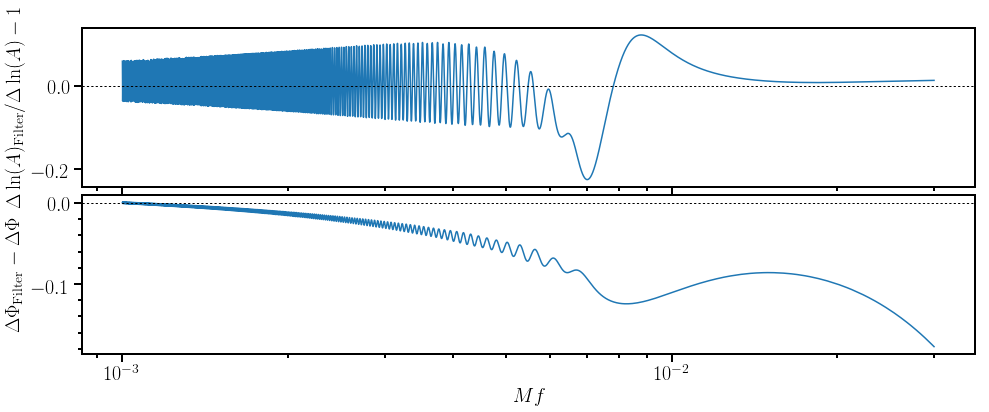

In [25]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h1, h2, hf21])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(100, 1000)

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh1, dh2])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.015, -0.010)
#ax1.set_ylim(-0.05, 0.)
ax1.set_ylim(-0.5, 0)

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dh1, dh2)
#ax2.set_ylim(-0.2, 0.2)
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Filter}/\Delta\ln(A) - 1$')
ax2.set_ylabel(r'$\Delta\Phi_{\rm Filter}-\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

# 1d slice to check smoothness (the parameters are mislabeled, so the dh waveform set will be garbage)

In [399]:
orig_filename = '../../data/teobtest40hz/TEOB_data_1d.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


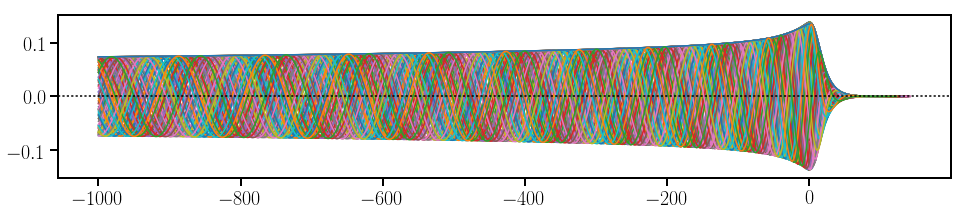

In [400]:
params_clean = params
hlist_clean = hlist

fig, ax = wave.plot_waveforms(hlist_clean, hc=True, xi=-1000, xf=200, npoints=10000)

In [366]:
mflow = f_to_mf(40., 2.)
print mflow

delta_t = 10.
winon_i = mflow
winon_f = 0.00050

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time
print n_ext
trunc_i = 0.0007
trunc_f = 0.03


h_filename = '../../data/teobtest40hz/h_test_1d.hdf5'
dh_filename = '../../data/teobtest40hz/dh_test_1d.hdf5'

traineob.condition_eob_training_set_from_list(
    hlist_clean, params_clean, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=0.2,
    filter_dfbyf_phase=0.05,
    plots=False, 
    mtot=2.0, distance=1.0)

0.000394039282043
17687982.9215
2097152
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [367]:
h_test = ws.HDF5WaveformSet('../../data/teobtest40hz/h_test_1d.hdf5')
dh_test = ws.HDF5WaveformSet('../../data/teobtest40hz/dh_test_1d.hdf5')

dh_test.parameters().shape

(51, 5)

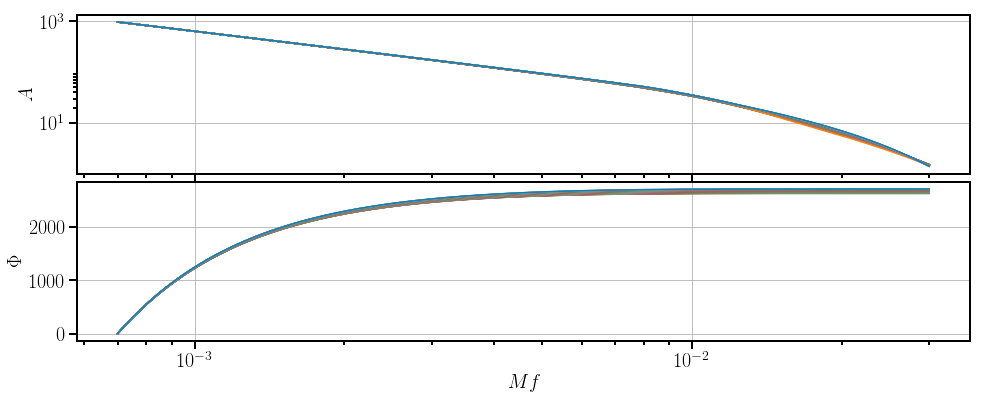

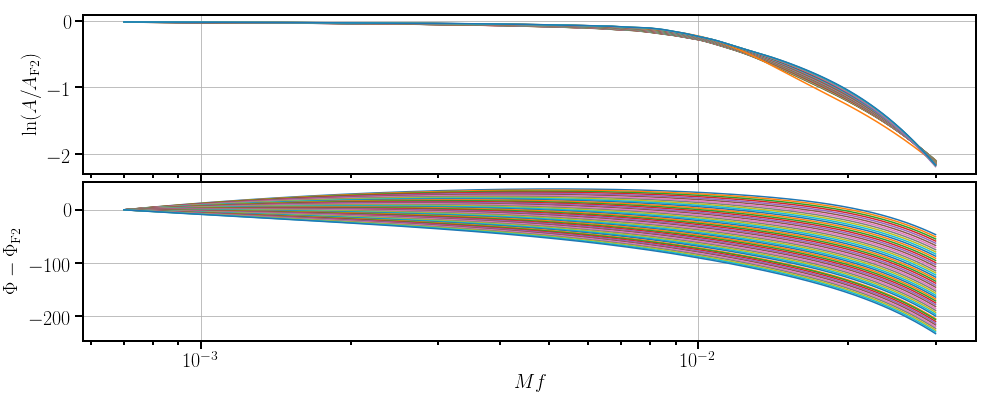

In [371]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_test[i] for i in range(len(h_test))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_test[i] for i in range(len(dh_test))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()
#ax1.set_ylim(-0.05, 0.0)

0.01 1015.12721759
-88.1917817888 -31.3120890883


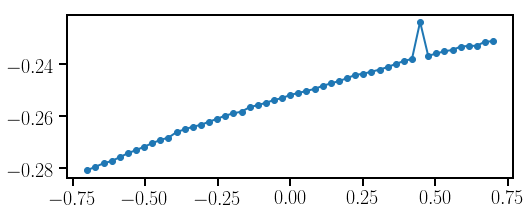

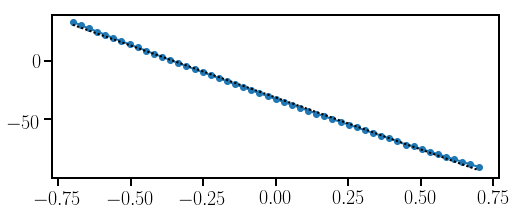

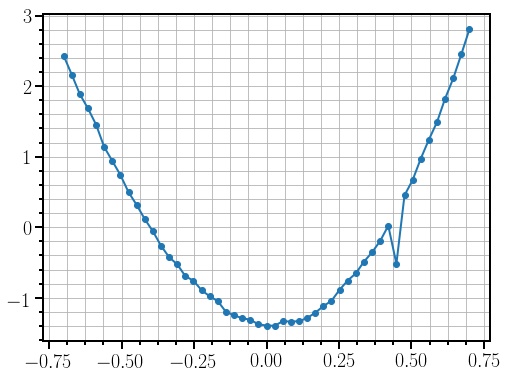

In [379]:
mf = 0.01
print mf, mf_to_f(mf, 2.)

spin1z_arr = np.array([dh_test.get_waveform(i, data='parameters')[1] for i in range(len(dh_test))])

ps = []
amps = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    h = dh_test[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(dh_test)):
    p = dh_test.get_waveform(i, data='parameters')[1]
    h = dh_test[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
print slope, intercept

x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)
axes.minorticks_on()
axes.grid(which='both')
#axes.set_ylim(-2, -1)

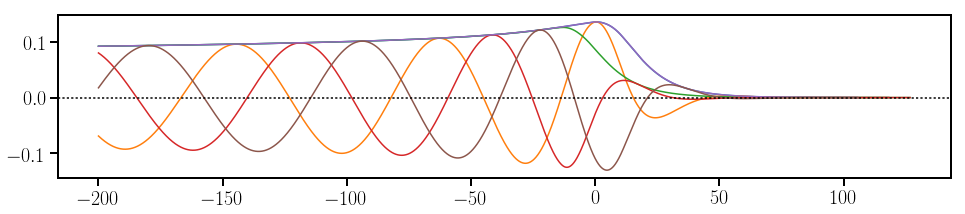

In [406]:
fig, ax = wave.plot_waveforms(hlist_clean[40:43], hp=True, hc=False, xi=-200, xf=200, npoints=10000)

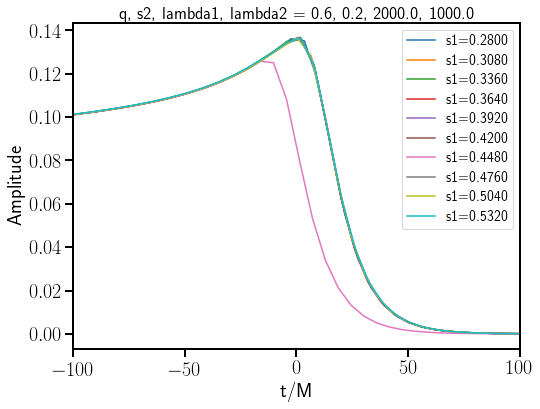

In [401]:
fig, ax = plt.subplots()
for i in range(35, 45):
    p = params_clean[i]
    h = hlist_clean[i]
    ax.plot(h.x, h.amp, label='s1={:.4f}'.format(p[1]))

ax.set_xlim(-100, 100)
ax.legend()
title = 'q, s2, lambda1, lambda2 = {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[2], p[3], p[4])
ax.set_title(title)
ax.set_xlabel('t/M')
ax.set_ylabel('Amplitude')

# Playing with low-pass filtering

In [409]:
from scipy.signal import hilbert, chirp

In [410]:
duration = 1.0
fs = 400.0
samples = int(fs*duration)
t = np.arange(samples) / fs

In [426]:
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
#signal += 0.5

In [430]:
# Convert real signal to complex signal with Hilbert transform
analytic_signal = hilbert(signal)
print analytic_signal

# Decompose complex signal into amplitude and phase
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

# Calculate frequency
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

[ 1.00000000-0.29786271j  0.97295768+0.12613297j  0.84319119+0.53077936j
  0.61685866+0.78562781j  0.31165687+1.00564738j -0.04395215+1.06441205j
 -0.41296169+1.03863128j -0.75341365+0.85137483j -1.02308934+0.58232898j
 -1.18482474+0.20063937j -1.21181324-0.20073125j -1.09216072-0.62016699j
 -0.83195160-0.96183027j -0.45619014-1.21673216j -0.00720057-1.30938274j
  0.45961030-1.25239606j  0.88233759-1.01309591j  1.20081779-0.64442396j
  1.36547650-0.16266236j  1.34549858+0.34327633j  1.13496981+0.82734622j
  0.75578765+1.194313j    0.25651065+1.40764623j -0.29311808+1.40726756j
 -0.81154718+1.20531737j -1.21755327+0.80538766j -1.44338742+0.28177776j
 -1.44679940-0.30486559j -1.21975789-0.84458368j -0.79202444-1.26444949j
 -0.22845951-1.47497957j  0.38004170-1.45042293j  0.93092382-1.17354369j
  1.32749560-0.70045004j  1.49662849-0.09534138j  1.40332339+0.52347889j
  1.05912096+1.05807534j  0.52224498+1.3964806j  -0.11119527+1.48526748j
 -0.72389097+1.29195108j -1.19916674+0.86123219j -1

(0.0, 120.0)

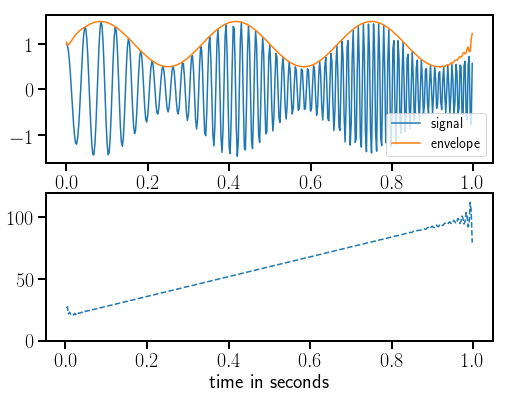

In [432]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(8, 6))

ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

ax1.plot(t[1:], instantaneous_frequency, ls='--')
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)

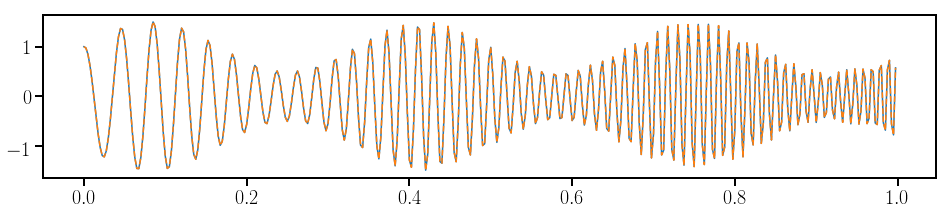

In [433]:
# Reconstruct original signal
reconstructed_signal = amplitude_envelope*np.exp(1.0j*instantaneous_phase)

fig, ax0 = plt.subplots(figsize=(16, 3))
ax0.plot(t, signal, label='signal')
ax0.plot(t, reconstructed_signal, ls='--', label='envelope')

In [17]:
# No moving average filter
h1, hf21, dh1 = condition_eob_waveform(
    h, p, delta_t,
    winon_i, winon_f,
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', 
    filter_dfbyf_amp=None, filter_dfbyf_phase=None, plots=False)

NameError: name 'condition_eob_waveform' is not defined

NameError: name 'dh1' is not defined

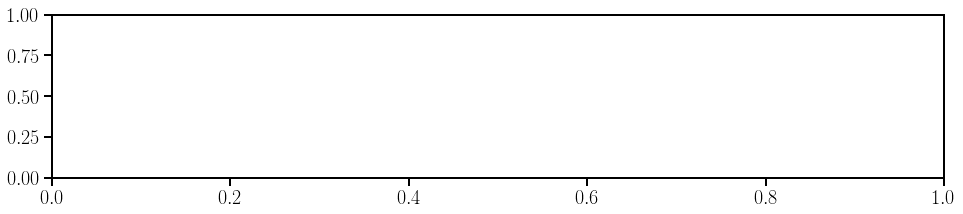

In [16]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(dh1.x, dh1.amp)
ax.set_ylim(-0.5, 0)

[-1957.93763631 -1950.78029564 -1943.63606107 ...,    -2.15346082
    -2.15364355    -2.15382628]


(-0.5, 0)

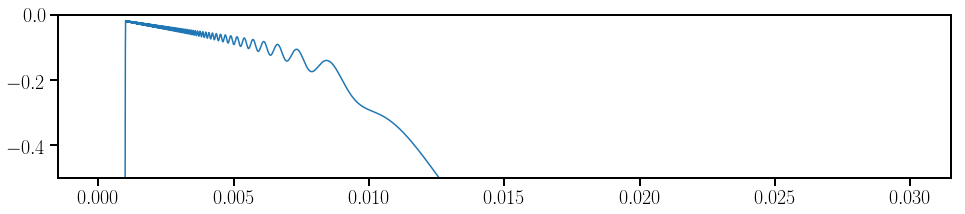

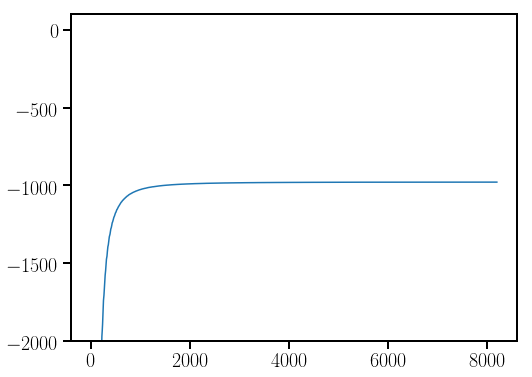

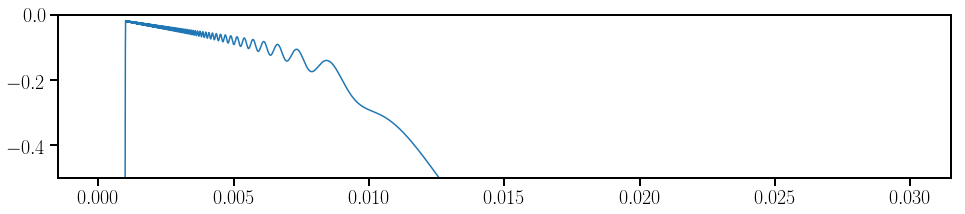

In [467]:
xs = np.linspace(0, 0.03, 2**14)
dhamp = dh1.interpolate('amp')(xs)
print dhamp

fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(xs, dhamp)
ax.set_ylim(-0.5, 0)

dhamp_tilde = np.fft.rfft(dhamp)

fig, ax = plt.subplots()
ax.plot(dhamp_tilde)
ax.set_ylim(-2000, 100)

#dhamp_tilde[2**8:] = 0.
#print dhamp_tilde
dhamp_low = np.fft.irfft(dhamp_tilde)

fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(xs, dhamp_low)
ax.set_ylim(-0.5, 0)

In [441]:
np.log2(n_ext)

21.0

In [ ]:
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
signal += 0.5